In [1]:
import scanpy as sc
import pandas as pd
import pickle
import time
import anndata
import sklearn.metrics
import statistics
import graph_tool.all as gt
%matplotlib notebook
%pylab

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
adata=sc.read('beta_parameter/adata_dropseq.h5ad')

In [3]:
g=pickle.load(open('beta_parameter/g_dropseq.pkl','rb'))

In [4]:
a=time.time()
state1=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state2=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state3=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
b=time.time()
b-a

51.54553270339966

In [8]:
pickle.dump(state1,open('new_alg_sets/dropseq/state1.pkl','wb'),2)
pickle.dump(state2,open('new_alg_sets/dropseq/state2.pkl','wb'),2)
pickle.dump(state3,open('new_alg_sets/dropseq/state3.pkl','wb'),2)

<IPython.core.display.Javascript object>


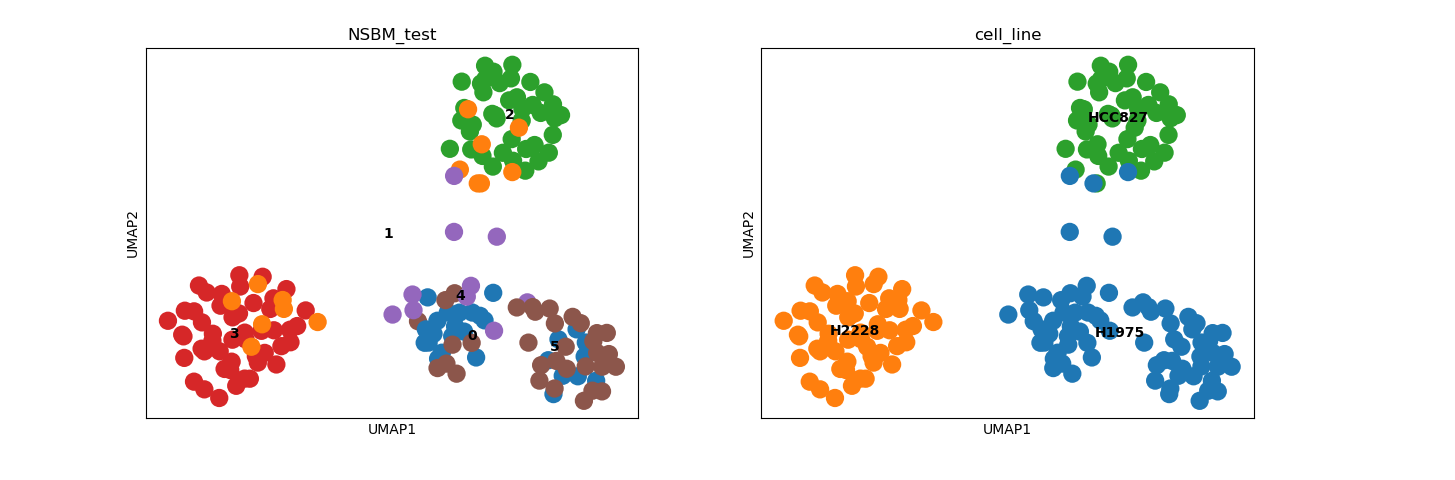

cell_line,H1975,H2228,HCC827
NSBM_test,,,
0,27,0,0
1,2,7,5
2,0,0,40
3,0,49,0
4,10,0,0
5,33,0,0


In [9]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state2.project_level(1).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

##### il peggiore è state 2 quindi faccio l'analisi con state 2

In [11]:
state=pickle.load(open('new_alg_sets/dropseq/state2.pkl','rb'))

# Anneal come facciamo ora (epsilon=0.001,nbreaks2,niter=10)

In [14]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

astate=state.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_anneal(astate,beta_range=(1,100), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0.001,mcmc_args=dict(niter=10)))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('new_alg_sets/dropseq/astate_e001_nm2_nit10.pkl','wb'),2)
astate

437.4931523799896


<NestedBlockState object, with base <BlockState object with 80 blocks (16 nonempty), for graph <Graph object, undirected, with 173 vertices and 3675 edges, 1 internal edge property, at 0x7f3c2c03cad0>, at 0x7f3c252621d0>, and 10 levels of sizes [(173, 16), (16, 4), (4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f3c252620d0>

<IPython.core.display.Javascript object>


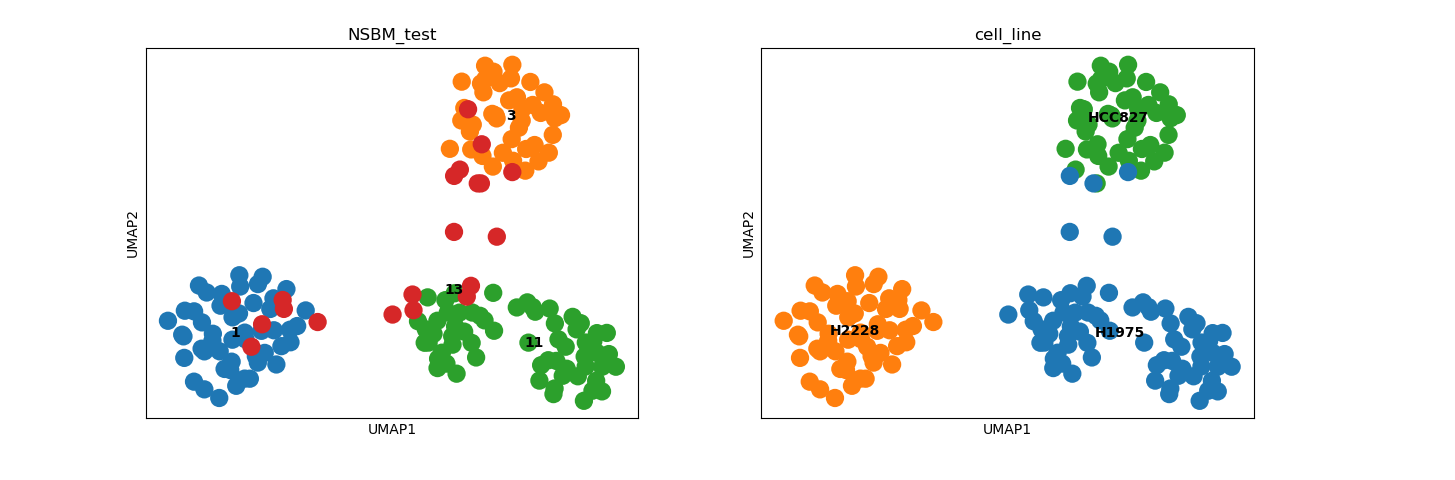

cell_line,H1975,H2228,HCC827
NSBM_test,,,
1,0,50,0
3,0,0,41
11,62,0,0
13,10,6,4


In [16]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(astate.project_level(1).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

#### il grafo è venuto bene, ma ci ha messo 440 secondi, per un subset di cellule piccolissimo
# sweep and Anneal niter=0, epsilon=0, nbreaks=2

In [33]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
a=time.time()
states=state.copy(bs=bs, sampling=True)
states.mcmc_sweep(niter=10000)
b=time.time()
bs = states.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
astate=states.copy(bs=bs, sampling=True)

gt.mcmc_anneal(astate,beta_range=(1,100), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0.001))
c=time.time()
d=b-a
e=c-b
print(d,e,d+e)
pickle.dump(state,open('new_alg_sets/dropseq/astate_e001_nm2_postsweep.pkl','wb'),2)
astate

4.094472885131836 65.98035478591919 70.07482767105103


<NestedBlockState object, with base <BlockState object with 78 blocks (14 nonempty), for graph <Graph object, undirected, with 173 vertices and 3675 edges, 1 internal edge property, at 0x7f3c2c03cad0>, at 0x7f3c24dea050>, and 10 levels of sizes [(173, 14), (14, 6), (6, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f3c24d6eb50>

<IPython.core.display.Javascript object>


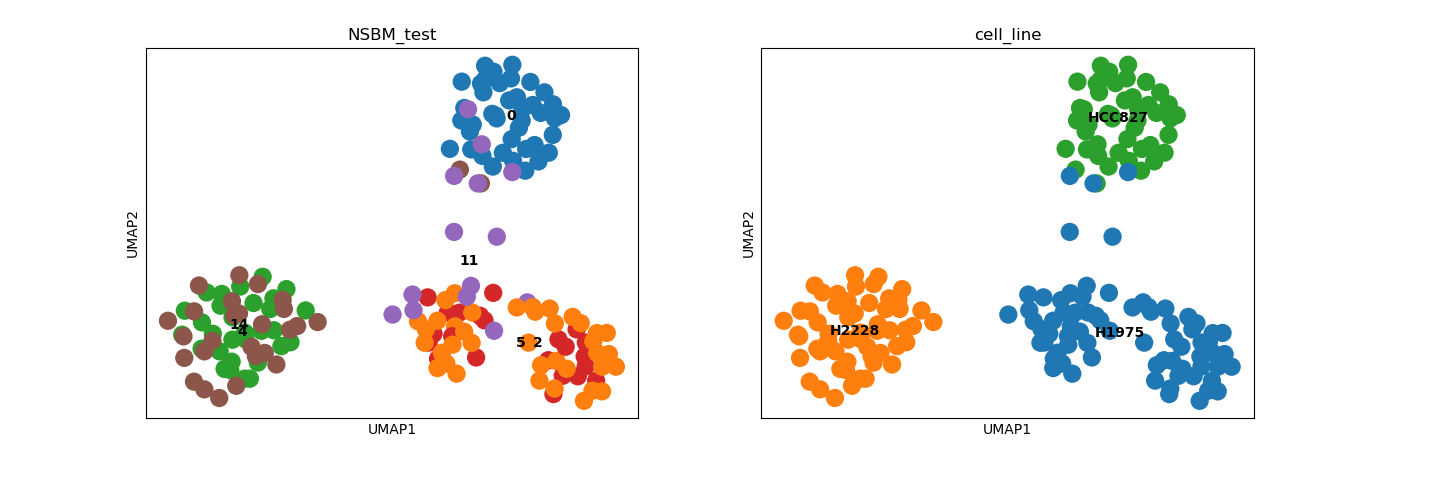

cell_line,H1975,H2228,HCC827
NSBM_test,,,
0,0,0,41
2,38,0,0
4,0,30,0
5,22,0,0
11,12,0,2
14,0,26,2


In [34]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(astate.project_level(1).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)